In [277]:
import json
import numpy as np
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import gensim
import pandas as pd
from climdist.data import load as load_df
from scipy.signal import find_peaks

In [2]:
model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('../data/models/word2vec_251021/w2v_model.txt')

In [3]:
df = load_df('main', readability=False, heading2=False)

In [173]:
with open('../pipeline/ner/ruler_patterns_171121.json', 'r', encoding='utf8') as f:
    patterns = [entry['pattern'] for entry in json.load(f)]

In [249]:
# load all entities captured by ruler
with open('../data/processed/entities_ruled.json', 'r', encoding='utf8') as f:
    ents_ruled = json.load(f)

## Normalize the entities

In [179]:
### normalize patterns: orthography, plural->singular, genitiv->nominativ, preserve meaning

def normalize_patterns(patterns):
    normalized = {}
    for word in patterns:
        print('\n\n', word)
        base_form = input('Enter the normalized form: ')
        if base_form:
            normalized[word] = base_form.capitalize()
            
    return normalized

In [182]:
### manually creating the normalization dictionary
### patterns_normalized = normalize_patterns(patterns)



 Welter
Enter the normalized form: wetter


 Witterung
Enter the normalized form: 


 Herbstwetter
Enter the normalized form: 


 Frühlingswetter
Enter the normalized form: 


 Werter
Enter the normalized form: wetter


 Regenwetter
Enter the normalized form: 


 Wetters
Enter the normalized form: wetter


 Sommerwetter
Enter the normalized form: 


 FrühlingSwetter
Enter the normalized form: frühlingswetter


 Witteruug
Enter the normalized form: witterung


 Winterwetter
Enter the normalized form: 


 Winde
Enter the normalized form: wind


 Regen
Enter the normalized form: 


 Maiwetter
Enter the normalized form: 


 Witternng
Enter the normalized form: witterung


 Nordwinde
Enter the normalized form: nordwind


 Regenschauern
Enter the normalized form: regenschauer


 WetterS
Enter the normalized form: wetter


 Regenschauer
Enter the normalized form: 


 Windstillen
Enter the normalized form: windstille


 Nordostwinde
Enter the normalized form: nordostwind


 Schneegestöber
En

Enter the normalized form: niederschlag


 Riederschlag
Enter the normalized form: niederschlag


 Reaen
Enter the normalized form: regen


 Echnee
Enter the normalized form: schnee


 Regenwolken
Enter the normalized form: regenwolke


 Blitzen
Enter the normalized form: blitz


 Schneeflocken
Enter the normalized form: 


 Donnerschlägen
Enter the normalized form: donnerschlag


 Flocken
Enter the normalized form: schneeflocken


 Mittagshitze
Enter the normalized form: 


 Regentropfen
Enter the normalized form: 


 Hagelwetter
Enter the normalized form: 


 Wolkenbruche
Enter the normalized form: wolkenbruch


 Windhose
Enter the normalized form: 


 Gewittersturm
Enter the normalized form: 


 Orkan
Enter the normalized form: 


 Aschenregen
Enter the normalized form: 


 Wolkenbrüchen
Enter the normalized form: wolkenbruch


 Wirbelwind
Enter the normalized form: 


 Wirbelsturm
Enter the normalized form: 


 Hagelschlag
Enter the normalized form: 


 Schlossen
Enter the normaliz

In [207]:
### save the dictionary

#with open('../pipeline/ner/wea_patterns_normalised_050422.json', 'w', encoding='utf8') as f:
#   json.dump(patterns_normalized, f)

### load the dictionary
with open('../pipeline/ner/wea_patterns_normalised_050422.json', 'r', encoding='utf8') as f:
    normalization_dict = json.load(f)

In [373]:
patterns_norm = set(list(normalization_dict.values()))

## Create dataframe with counts

In [442]:
def create_wea_df(ents, patterns, normalization_dict):
    
    for word in patterns:
        if word not in normalization_dict.keys():
            normalization_dict[word] = word

    cols = set(sorted(list(normalization_dict.values())))
    df = pd.DataFrame(0, index=range(1802,1889), columns=cols)
    
    for entry in tqdm(ents):
        if len(entry['ents']['WEA']) > 0:
            yr = int(entry['date'][:4])
            for ent in entry['ents']['WEA']:
                #print(df.loc[yr, normalization_dict[ent[0]]])
                df.loc[yr, normalization_dict[ent[0]]] += 1
                
    df['total'] = df.sum(axis=1)
    
    return df

    
wea_df = create_wea_df(ents_ruled, patterns, normalization_dict)

100%|████████████████████████████████████████████████████████████████████████| 289705/289705 [00:41<00:00, 6973.32it/s]


In [444]:
wea_df

NNO  Südostwind  Hagelschauer  Klima  Südwestwind  Schlossen  \
1802    0           0             0      2            0          0   
1803    0           0             0      4            0          0   
1804    0           0             0      1            0          0   
1805    0           1             0      1            0          1   
1806    0           0             0      3            0          0   
...   ...         ...           ...    ...          ...        ...   
1884    0           2             1    103           11          1   
1885    6           1             4     97            4          3   
1886   68           1             0     94            2          5   
1887   29           9             1     81           16          7   
1888    8           9             2     58           14          4   

      Überschwemmung  Stosse  Südweststurm  Regenzeit  ...  Hochfluth  \
1802               2       0             0          0  ...          0   
1803               1       0             0          1  ...          0   
1804               8       0             0          0  ...          0   
1805               2       1             0          0  ...          0   
1806               0       0             0          0  ...          0   
...              ...     ...           ...        ...  ...        ...   
1884              43       3             1          3  ...          4   
1885              27       5             2          7  ...          9   
1886              32       7             0          4  ...          4   
1887              36      10             0          4  ...          3   
1888              66       5             0          8  ...          8   

      Sommerwärme  Wolkenbruch  Frühlingswetter  Schneeschmelz  Witterung  \
1802            0            0                1              0          4   
1803            0            0                0              0         11   
1804            0            2                0              0         23   
1805            0            0                1              0         13   
1806            0            0                0              0         10   
...           ...          ...              ...            ...        ...   
1884            0            4                2              0        220   
1885            3            6                5              1        198   
1886            1            6                3              0        181   
1887            3            4                3              0        235   
1888            0            6                6              1        279   

      Landregen  Sonnenwärme  Luftzug  total  
1802          0            0        0    151  
1803          0            0        0    182  
1804          0            1        0    259  
1805          0            0        0    141  
1806          0            0        0    130  
...         ...          ...      ...    ...  
1884          2            6        1   3967  
1885          2            2        1   3726  
1886          2            2        1   3878  
1887          0            3        1   4655  
1888          4            3        0   4599  

[87 rows x 142 columns]

In [443]:
wea_df.to_csv('../data/processed/wea_freq.tsv', sep='\t', encoding='utf8')

### Distribution of entities (Zipf)

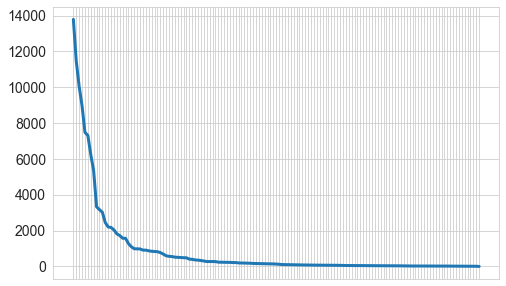

In [478]:
plt.figure(figsize=(8,5))
wea_df.loc[:, wea_df.columns != 'total'].sum(axis=0).sort_values(ascending=False).plot(linewidth=3)
plt.xticks(range(len(wea_df.columns)-1), labels=[])
plt.yticks(fontsize=14)
plt.savefig('../references/inalco/zipf.png', bbox_inches='tight')
plt.show()

## Wordclouds

In [301]:
wea_freqs = {key: value for (key, value) in sorted(wea_df.sum().to_dict().items(), key=lambda x:x[1], reverse=True)}
wea_freqs_early = wea_df.loc[:1859].sum().to_dict()
wea_freqs_late = wea_df.loc[1860:].sum().to_dict()

### General wordcloud

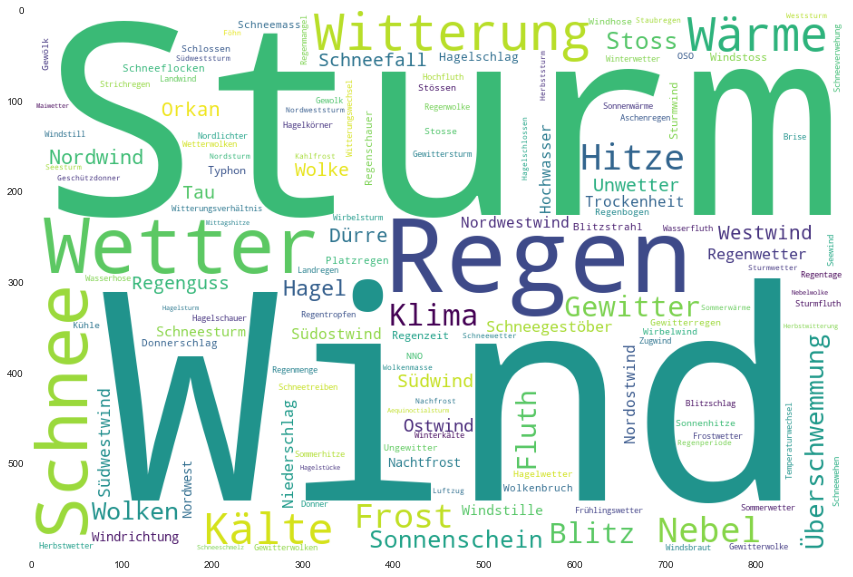

In [263]:
#plt.figure(figsize=(12,8))
wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(wea_freqs)
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.grid(None)
plt.savefig('../references/inalco/general_cloud_050422.png', bbox_inches='tight')
plt.show()

### 1802-1859 wordcloud

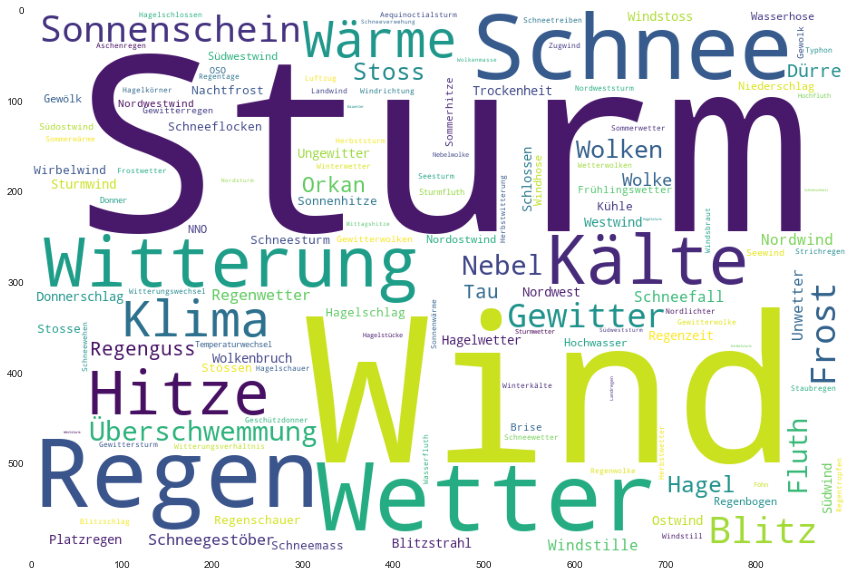

In [266]:
#plt.figure(figsize=(12,8))
wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(wea_freqs_early)
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.grid(None)
#plt.savefig('../references/inalco/general_cloud_050422.png', bbox_inches='tight')
plt.show()

## 1860-1888 wordcloud

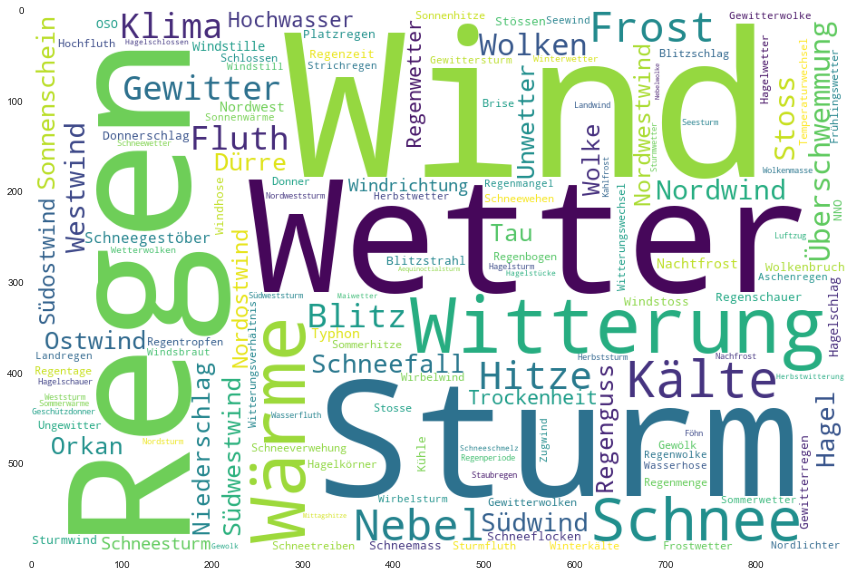

In [269]:
#plt.figure(figsize=(12,8))
wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(wea_freqs_late)
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.grid(None)
#plt.savefig('../references/inalco/general_cloud_050422.png', bbox_inches='tight')
plt.show()

In [307]:
wea_df['total'] = wea_df.sum(axis=1)

# Frequency plots

### Total count of ents wrt text mass

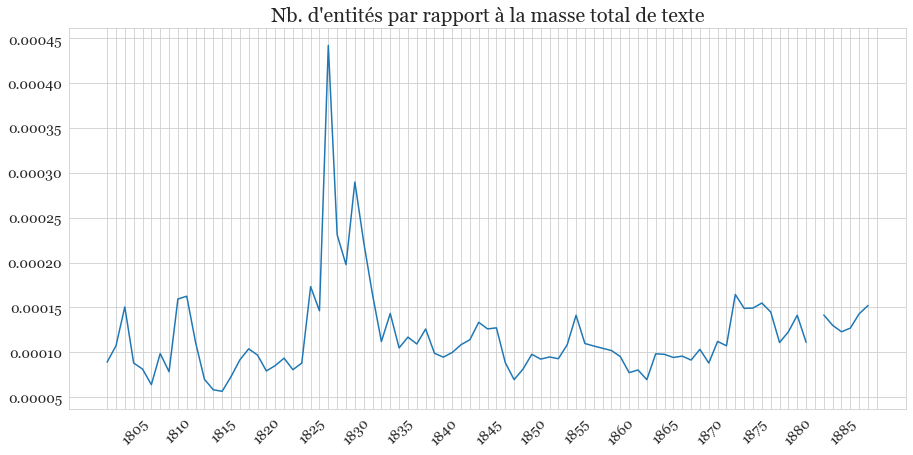

In [426]:
matplotlib.rcParams['font.family'] = 'georgia'
ticksrange = np.arange(1802,1890)
xlabels = [num if num%5==0 else '' for num in np.arange(1802,1890)]

fig = plt.figure(figsize=(15,7))
(wea_df.total/df.groupby('year')['text_len'].sum().reindex(range(1802,1889)).fillna(0)).plot()
plt.grid(b=True, which='both')
plt.yticks(fontsize=14)
plt.xticks(ticks=ticksrange, labels=xlabels, fontsize=14)
plt.tick_params(axis ='x', rotation = 45)
plt.title("Nb. d'entités par rapport à la masse total de texte", fontsize=20)
#plt.ylabel("Nb. d'articles", fontsize=20)
#plt.legend(fontsize = 14)
sns.set_style(style='ticks')

plt.savefig('../references/inalco/entities_per_mass.png', bbox_inches='tight')

plt.show()

### Correlation between the above graph and different entities

In [422]:
corrs = {}

for name in wea_df.columns:
    corrs[name] = wea_df.loc[1820:1835,name].corr(wea_df.total/df.groupby('year')['text_len'].sum().reindex(range(1802,1889)).fillna(0))

{key: value for (key, value) in sorted(corrs.items(), key=lambda x:x[1], reverse=True)}

{'Überschwemmung': 0.47846453056767996,
 'Südwestwind': 0.4247835226885841,
 'NNO': 0.27352901039065125,
 'Südostwind': 0.20510904280077738,
 'Klima': 0.19728001517803137,
 'Südweststurm': nan,
 'Springfluth': nan,
 'Regentropfen': nan,
 'Windsbraut': nan,
 'Witterungswechsel': nan,
 'Fluth': 0.42179582047503866,
 'Kälte': 0.41415403562095227,
 'Schlossen': 0.28525742403025267,
 'Westwind': 0.2762709604937345,
 'Nordostwind': 0.17116477079554218,
 'Wärme': 0.14034441105357037,
 'Nordwind': 0.12171795978450567,
 'Südwind': 0.01117563276276263,
 'Temperaturwechsel': 0.008452466349680799,
 'Hagelschauer': -0.00950801191900339,
 'Trockenheit': -0.022136258387503084,
 'Landwind': -0.14844777201509143,
 'Stoss': -0.15380261645575452,
 'Donnerschlag': -0.16401060108849197,
 'Wasserfluth': nan,
 'Schneewetter': 0.020187440589344553,
 'Regenzeit': -0.12047320562564377,
 'Herbststurm': -0.14844777201509143,
 'Windhose': -0.16612725673144307,
 'Stosse': -0.1684718597336674,
 'Hagelkörner': -0.216

### Plots for single entities and entity groups

In [438]:
def entity_plot(ents, wea_df, kind='line', relative=True, savepath=None):
    
    matplotlib.rcParams['font.family'] = 'georgia'
    col = sns.color_palette("muted", len(ents))

    plt.figure(figsize=(15,7))
    ticksrange = np.arange(1802,1890)
    xlabels = [num if num%5==0 else '' for num in np.arange(1802,1890)]
    
    if kind == 'line':
        if relative == True:
            for word in ents:
                plt.plot(wea_df[word]/wea_df.total, label=word)
        else:
            for word in ents:
                plt.plot(wea_df[word], label=word)
            
    if kind == 'stack':
        if relative == True:
            plt.stackplot(np.arange(1802,1889),
                          [wea_df[word]/wea_df.total for word in ents],
                          labels=ents,
                          colors=col)
        else:
            plt.stackplot(np.arange(1802,1889), [wea_df[word] for word in ents], labels=ents)
            
    
    plt.grid(b=True, which='both')
    plt.yticks(fontsize=14)
    plt.xticks(ticks=ticksrange, labels=xlabels, fontsize=14)
    plt.tick_params(axis ='x', rotation = 45)
    plt.setp(plt.gca().spines.values(), color='black')
    plt.gca().set_frame_on(True)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], loc='upper left', fontsize=12)
    #plt.title('Distribution temporelle des données', fontsize=20)
    if relative == True:
        plt.ylabel("Proportion de toutes les entités", fontsize=18)
    else:
        plt.ylabel("Nb. d'occurrences", fontsize=18)
        
    sns.set_style(style='whitegrid')
    
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    
    plt.show()

#### Wetter/Witterung/Klima

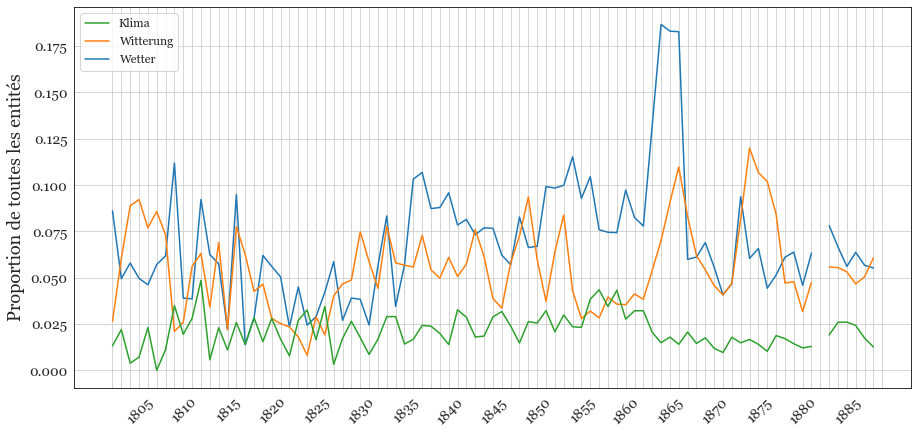

In [433]:
entity_plot(['Wetter', 'Witterung', 'Klima'], wea_df, kind='line',
            savepath='../references/inalco/wetter_witterung_klima.png')

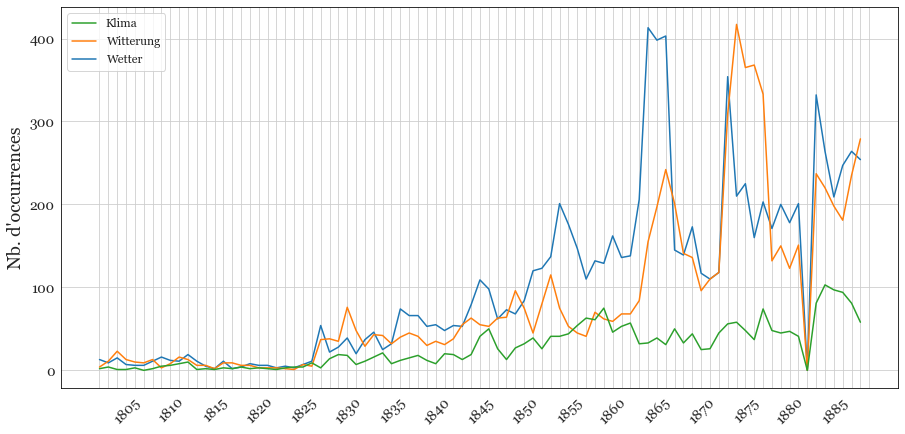

In [439]:
entity_plot(['Wetter', 'Witterung', 'Klima'], wea_df, kind='line', relative=False)

#### Most common ents

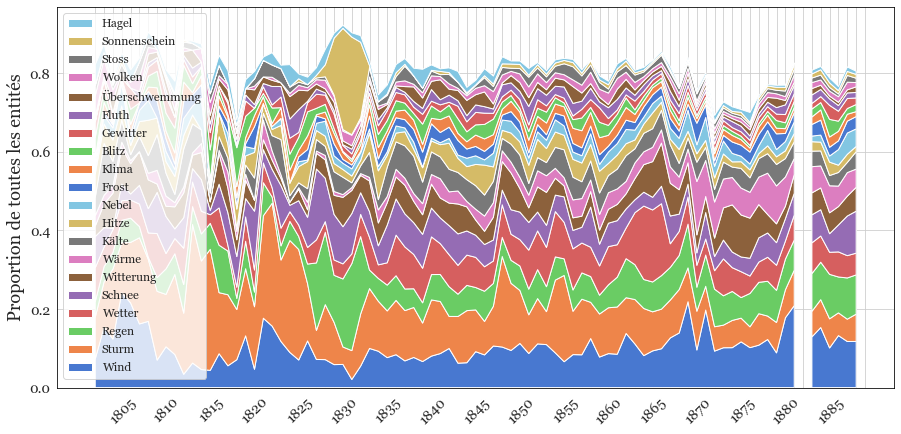

In [434]:
entity_plot(list(wea_freqs.keys())[:20], wea_df, kind='stack',
            savepath='../references/inalco/20_most_frequent_ents.png')

#### Winds

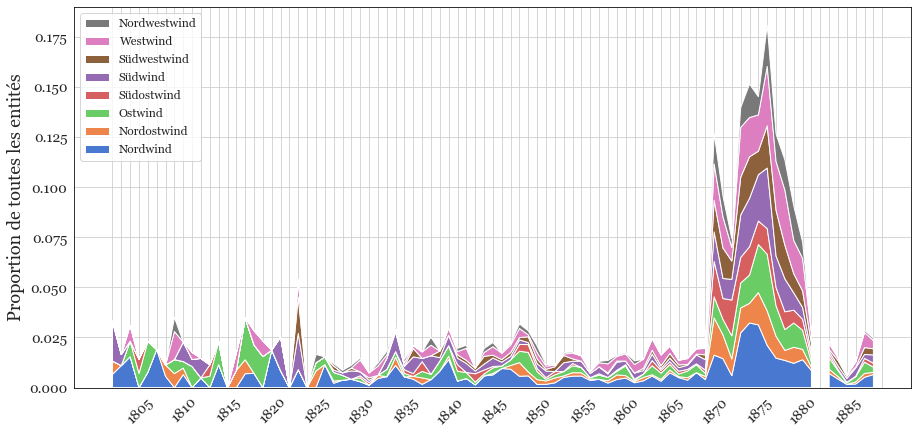

In [435]:
windlist = ['Nordwind', 'Nordostwind', 'Ostwind', 'Südostwind',
            'Südwind', 'Südwestwind', 'Westwind', 'Nordwestwind']
entity_plot(windlist, wea_df, kind='stack',
            savepath='../references/inalco/wind_directions.png')

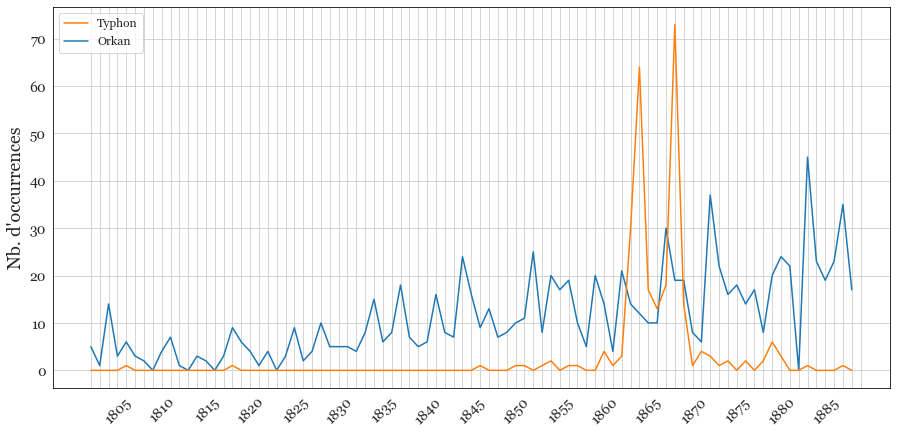

In [440]:
entity_plot(['Orkan', 'Typhon'], wea_df, kind='line', relative=False,
            savepath='../references/inalco/orkan_typhon.png')

['Regenzeit', 'Regentropfen', 'Regenmangel', 'Platzregen', 'Regenmenge', 'Regenbogen', 'Regenwetter', 'Gewitterregen', 'Regenperiode', 'Regenwolke', 'Regenschauer', 'Regentage', 'Aschenregen', 'Regenguss', 'Strichregen', 'Staubregen', 'Landregen']


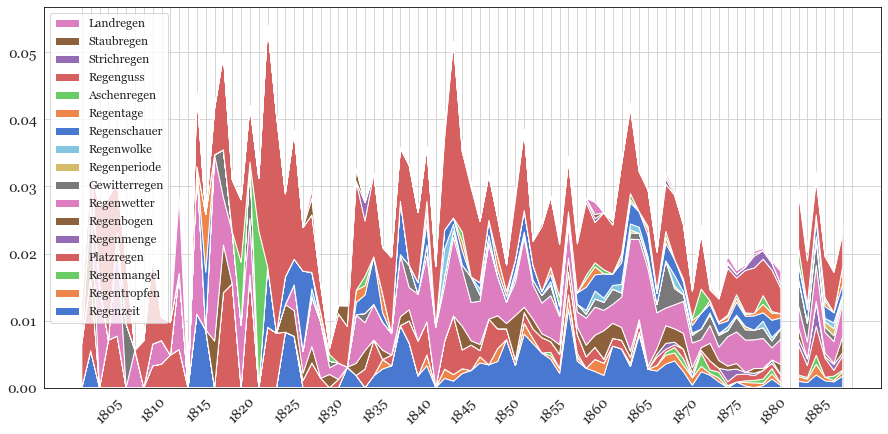

In [379]:
rainlist = [word for word in patterns_norm if 'regen' in word.lower() and word!='Regen']
print(rainlist)
entity_plot(rainlist, wea_df, kind='stack')

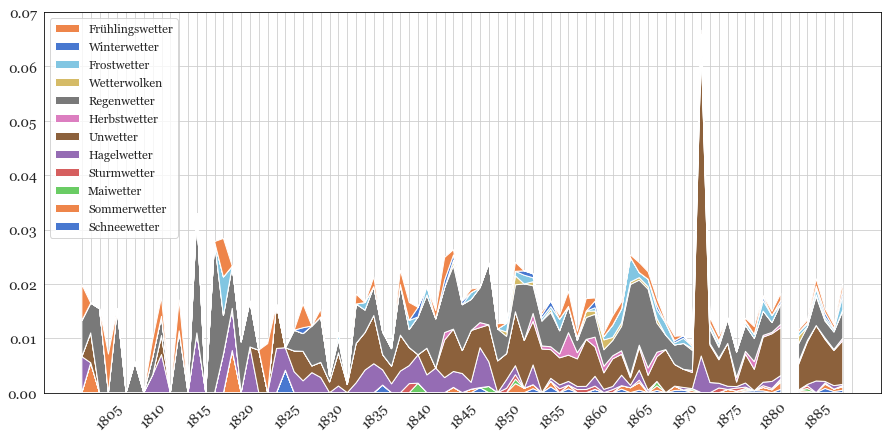

In [384]:
wetter_list = [word for word in patterns_norm if 'wetter' in word.lower() and word!='Wetter']
entity_plot(wetter_list, wea_df, kind='stack', relative=True)

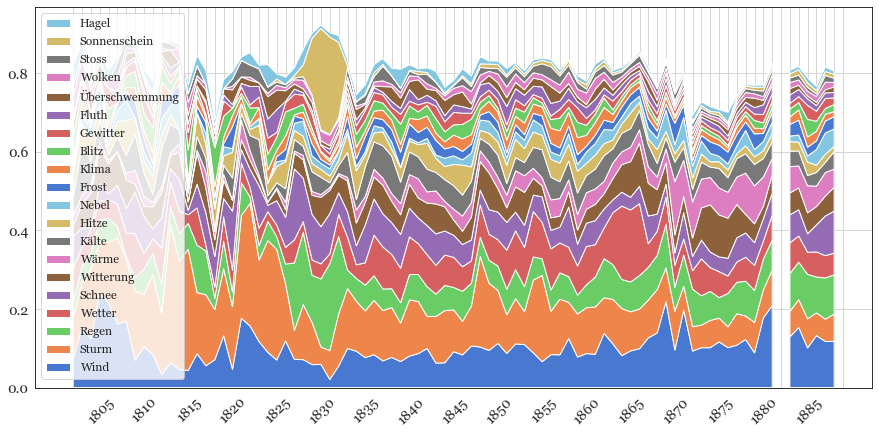

In [392]:
entity_plot(list(wea_freqs.keys())[:20], wea_df, kind='stack')

In [402]:
len(patterns_norm)

141

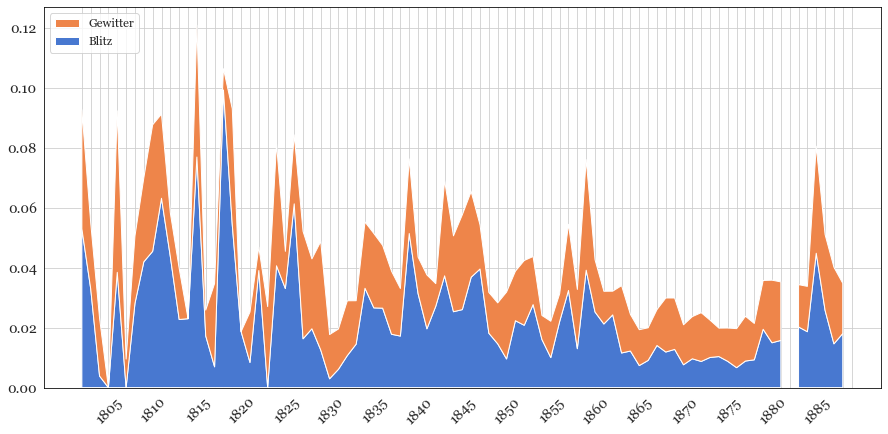

In [401]:
entity_plot(['Blitz', 'Gewitter', ], wea_df, kind='stack')

In [5]:
# total nb of entities detected

# ents_detected = 0
# 
# for entry in ents_ruled:
#     ents_detected += len(entry['ents']['WEA'])
# 
# print(ents_detected)

122281


In [7]:
def find_wea_freqs(ents):
    
    results = {}
    
    for entry in tqdm(ents):
        wea_ents = entry['ents']['WEA']
        if len(wea_ents) != 0:
            for ent in wea_ents:
                if ent[0] in results.keys():
                    results[ent[0]] += 1
                else:
                    results[ent[0]] = 1
                    
    return {key: value for (key, value) in sorted(results.items(), key=lambda x:x[1], reverse=True)}

In [67]:
wea_freqs = find_wea_freqs(ents)

100%|██████████████████████████████████████████████████████████████████████| 256996/256996 [00:00<00:00, 543839.55it/s]


In [154]:
wea_freqs_ruled = find_wea_freqs(ents_ruled)

100%|██████████████████████████████████████████████████████████████████████| 289705/289705 [00:00<00:00, 862198.38it/s]


In [10]:
with open('../data/processed/wea_freq_counts.json', 'w', encoding='utf8') as f:
    json.dump(wea_freqs, f)
        
with open('../data/processed/wea_freq_counts_ruled.json', 'w', encoding='utf8') as f:
    json.dump(wea_freqs_ruled, f)

In [15]:
ents_early = [entry for entry in ents_ruled if entry['date'][:4] in [str(i) for i in range(1802,1860)]]
ents_late = [entry for entry in ents_ruled if entry['date'][:4] in [str(i) for i in range(1860,1889)]]

In [19]:
wea_freqs_early = find_wea_freqs(ents_early)
wea_freqs_late = find_wea_freqs(ents_late)

100%|██████████████████████████████████████████████████████████████████████| 143687/143687 [00:00<00:00, 915268.77it/s]


In [165]:
def get_counts_by_year(ents):
    year_freqs = {}
    for entry in ents:
        yr = int(entry['date'][:4])
        if yr in year_freqs.keys():
            year_freqs[yr] += len(entry['ents']['WEA'])
        else:
            year_freqs[yr] = len(entry['ents']['WEA'])
            
    return year_freqs

In [166]:
year_freqs = get_counts_by_year(ents_ruled)

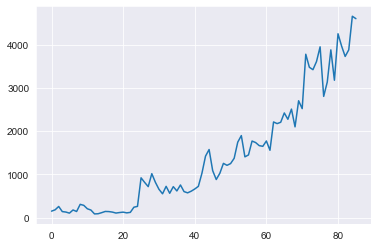

In [170]:
plt.plot(year_freqs.values())

## Wordclouds for all entities

In [21]:
#plt.figure(figsize=(12,8))
#wc = WordCloud(background_color='white', width=900, height=600)
#wc.generate_from_frequencies(wea_freqs)
#plt.figure(figsize=(15,10))
#plt.imshow(wc)
##plt.savefig('../references/inalco/general_cloud_ner.png', bbox_inches='tight')
#plt.show()

<Figure size 864x576 with 0 Axes>

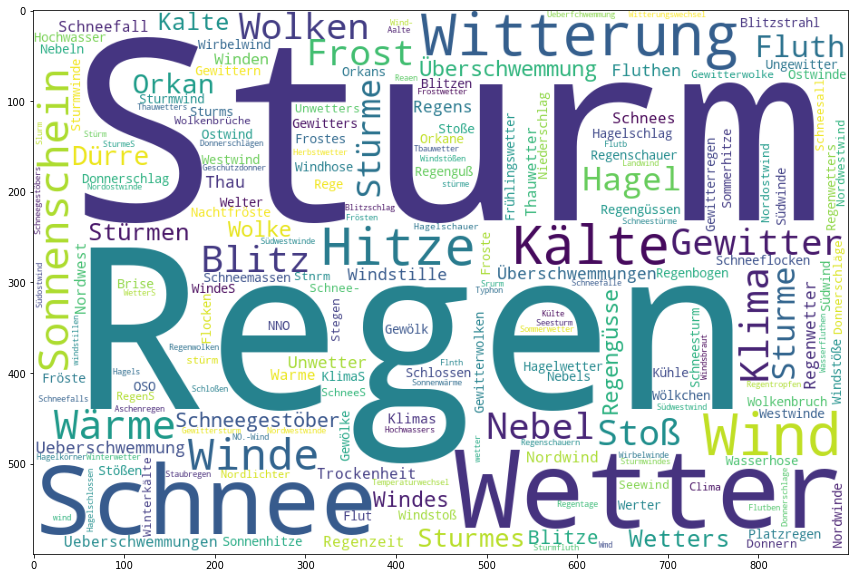

In [22]:
plt.figure(figsize=(12,8))
wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(wea_freqs_early)
plt.figure(figsize=(15,10))
plt.imshow(wc)
#plt.savefig('../references/inalco/general_cloud_ruled.png', bbox_inches='tight')
plt.show()

<Figure size 864x576 with 0 Axes>

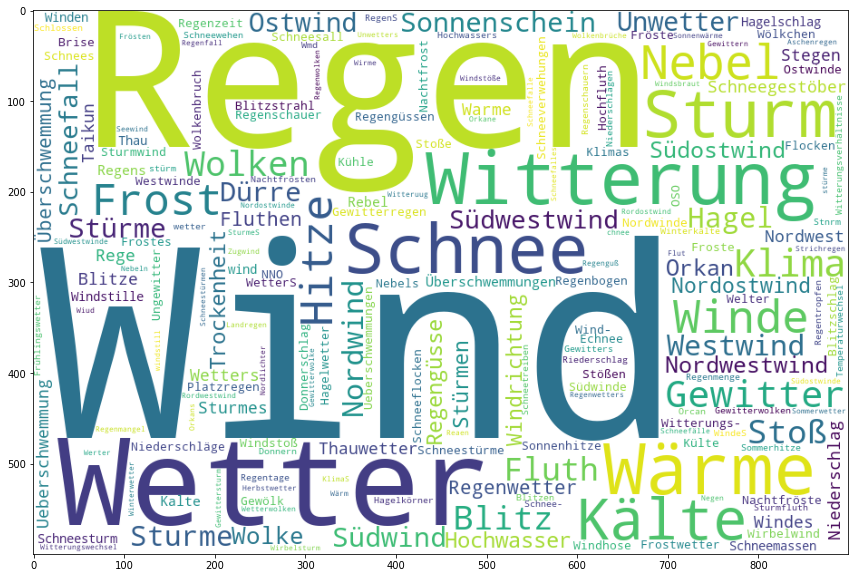

In [23]:
plt.figure(figsize=(12,8))
wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(wea_freqs_late)
plt.figure(figsize=(15,10))
plt.imshow(wc)
#plt.savefig('../references/inalco/general_cloud_ruled.png', bbox_inches='tight')
plt.show()

## Comparison of wea entities in 1802-1859 and 1860-1888

In [31]:
print(f'''Out of a total of {len(wea_freqs_late.keys())} different WEA keywords, 
{len(wea_freqs_late.keys())-len(wea_freqs_early.keys())} appear only in the later period:
{[key for key in wea_freqs_late.keys() if key not in wea_freqs_early.keys()]}''')

Out of a total of 333 different WEA keywords, 
11 appear only in the later period:
['Taikun', 'Regenmenge', 'Rordostwind', 'Rordwestwind', 'Regenperiode', 'Regm', 'Südwestwiud', 'Eüdwestwind', 'Sudwestwind', 'Nordostwiud', 'Nortostwind']


In [44]:
wea_freqs_early['Sturm']

3193

In [99]:
df_freqs = pd.DataFrame(data=[wea_freqs_early, wea_freqs_late]).transpose()
df_freqs.columns = ['early', 'late']
#df_freqs.sort_values(by='late', ascending=False)[:20]
df_freqs['total'] = df_freqs.early + df_freqs.late
df_freqs['early_w'] = df_freqs.early/df_freqs.early.sum()
df_freqs['late_w'] = df_freqs.late/df_freqs.late.sum()
df_freqs['difference_w'] = df_freqs.early_w - df_freqs.late_w

In [117]:
df_freqs[['early', 'late', 'difference_w']].sort_values(by='difference_w', ascending=True).iloc[:20]

early    late  difference_w
Wind          1866.0  7670.0     -0.042435
Wärme          864.0  4860.0     -0.035217
Witterung     1924.0  5166.0     -0.011128
Regen         2533.0  6237.0     -0.007938
Westwind        49.0   768.0     -0.007855
Nebel          678.0  2052.0     -0.006676
Nordwind       114.0   751.0     -0.005952
Südwestwind     16.0   532.0     -0.005911
Südwind         68.0   621.0     -0.005609
Ostwind         59.0   580.0     -0.005357
Südostwind      17.0   412.0     -0.004457
Frost          634.0  1765.0     -0.004413
Nordwestwind    24.0   401.0     -0.004143
Windrichtung     7.0   344.0     -0.003909
Nordostwind     22.0   348.0     -0.003565
Hochwasser      38.0   382.0     -0.003551
Schneefall     123.0   538.0     -0.003183
Wetter        2433.0  5602.0     -0.002999
Stegen          23.0   271.0     -0.002622
Rebel            8.0   229.0     -0.002515

In [85]:
df_freqs.early.sum()

38226.0

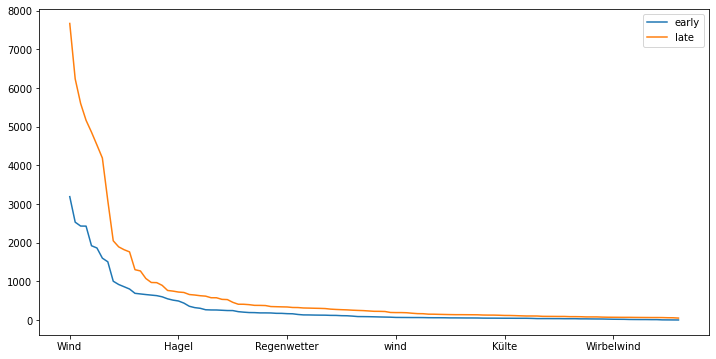

In [83]:
plt.figure(figsize=(12,6))

df_freqs[df_freqs.total > 100].sort_values(by='early', ascending=False).early.plot()
df_freqs[df_freqs.total > 100].sort_values(by='late', ascending=False).late.plot()
#plt.xscale('log')
plt.legend()
plt.show()

## Single entity frequencies

<AxesSubplot:xlabel='year'>

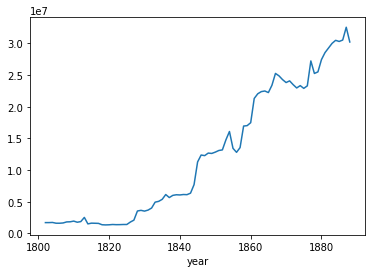

In [159]:
text_lens = df.groupby('year')['text_len'].sum()
text_lens.plot()

In [27]:
with open('../pipeline/ner/ruler_patterns_171121.json', 'r', encoding='utf8') as f:
    wea_patterns = json.load(f)
    wea_patterns = [entry['pattern'] for entry in wea_patterns]

In [36]:
orkan_list = ['Orkan', 'Orkane', 'Orcan', 'Orkans']
sturm_list = ['Sturm', 'Weststurm', 'SturmeS', 'Schneestürme', 'Schneesturm', 'Schneestürmen', 'Unwetter', 'Sturmwind',
              'Schneesturme', 'Sturmwinde', 'Gewittersturm', 'Orkane', 'Orcan', 'Orkan', 'Orkans', 'Stürm',
              'Stnrm', 'Wirbelwinde', 'Südweststurm', 'Nordsturm', 'Nordweststurm', 'Ungewitter', 'Sturmwetter',
              'Sturmwetter', 'Sturms', 'Schneesturmes', 'Stnrmes', 'Sturmwindes', 'Wirbelwindes', 'Herbststürme',
              'Srurm', 'Slurm', 'Stürme', 'Stürmen', 'Eturm', 'stürme', 'stürm', 'Seesturm', 'Gewitterstürme',
              'Aequinoctialstürme', 'Stnrme', 'Typhon', 'Taikun']
exotic_wind_list = ['Typhon', 'Taikun', 'Aequinoctialstürme']

In [41]:
wetter_witterung_list = ['Wetter', 'Welter', 'Witterung', 'Herbstwetter', 'Frühlingswetter', 'Werter',
                         'Wetters', 'Sommerwetter', 'FrühlingSwetter', 'Witteruug', 'Winterwetter', 'Maiwetter',
                         'Witternng', 'WetterS', 'Welters']
klima_list = ['Klima', 'Klimas', 'Clima', 'KlimaS']

In [162]:
def get_peaks(results, n=3):
    peaks = find_peaks(list(results.values()), distance=2, height=min(results.values()))
    peaks_dict = dict(zip(peaks[0], peaks[1]['peak_heights']))
    peaks_sorted = {key+1802: value for (key, value) in sorted(peaks_dict.items(), key=lambda x:x[1], reverse=True)}

    peaks_xy = []
    for num, peak in enumerate(peaks_sorted.items()):
        if num < n:
            peaks_xy.append(peak)
    
    return peaks_xy


def find_single_entity_freq(ents, target_list):
    
    results = {}
    
    for entry in ents:
        if len(entry['ents']['WEA']) > 0:
            year = int(entry['date'][:4])
            for ent in entry['ents']['WEA']:
                if ent[0] in target_list:
                    if year in results.keys():
                        results[year] += 1
                    else:
                        results[year] = 1
                        
    results_proportional = {}
    for key, value in results.items():
        results_proportional[key] = results[key]/text_lens[key]
    
    sns.set_style('darkgrid')
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
    figure.tight_layout()
    
    ax1.plot(results.keys(), results.values(), label=target_list[0])
    ax1.set_title(f'"{target_list[0]}" occurrences')
    ax2.plot(results_proportional.keys(), results_proportional.values(), label=target_list[0])
    ax2.set_title(f'"{target_list[0]}" relative share')
    
    for peak in get_peaks(results):
        ax1.annotate(str(peak[0]), peak)
    for peak in get_peaks(results_proportional):
        ax2.annotate(str(peak[0]), peak)
    
    plt.legend()
    plt.show()

{'Wind': 9536,
 'Regen': 8770,
 'Wetter': 8035,
 'Sturm': 7384,
 'Witterung': 7090,
 'Schnee': 6959,
 'Wärme': 5724,
 'Kälte': 4691,
 'Hitze': 3330,
 'Winde': 2902,
 'Nebel': 2730,
 'Frost': 2399,
 'Klima': 2110,
 'Gewitter': 1966,
 'Wolken': 1725,
 'Blitz': 1636,
 'Stoß': 1574,
 'Sonnenschein': 1572,
 'Fluth': 1341,
 'Hagel': 1245,
 'Sturme': 1212,
 'Stürme': 1184,
 'Dürre': 987,
 'Nordwind': 865,
 'Westwind': 817,
 'Orkan': 770,
 'Unwetter': 755,
 'Wolke': 710,
 'Südwind': 689,
 'Schneefall': 661,
 'Ostwind': 639,
 'Regengüsse': 626,
 'Stürmen': 616,
 'Sturmes': 607,
 'Überschwemmung': 584,
 'Wetters': 574,
 'Südwestwind': 548,
 'Schneegestöber': 522,
 'Fluthen': 514,
 'Regenwetter': 509,
 'Trockenheit': 507,
 'Windes': 497,
 'Kalte': 491,
 'Ueberschwemmung': 489,
 'Blitze': 455,
 'Warme': 444,
 'Überschwemmungen': 433,
 'Südostwind': 429,
 'Nordwestwind': 425,
 'Hochwasser': 420,
 'Thauwetter': 414,
 'Regens': 389,
 'Windstille': 378,
 'Nordostwind': 370,
 'Thau': 367,
 'Nordwest': 

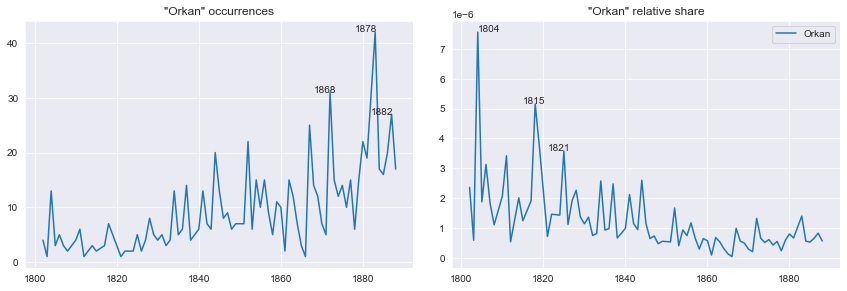

In [163]:
find_single_entity_freq(ents_ruled, ['Orkan'])

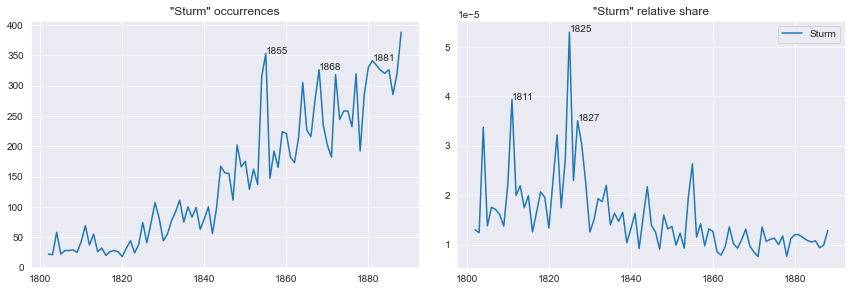

In [195]:
find_single_entity_freq(ents_ruled, sturm_list)

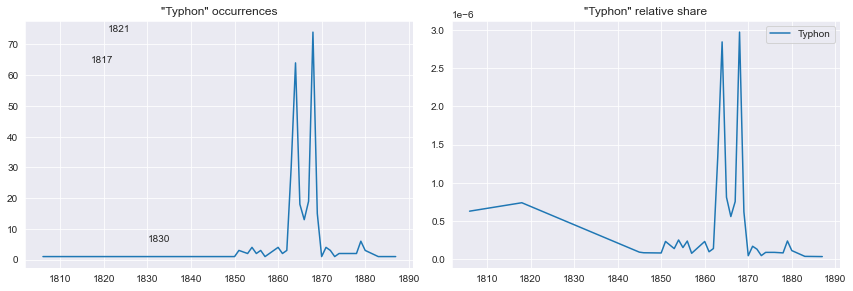

In [209]:
find_single_entity_freq(ents_ruled, exotic_wind_list)

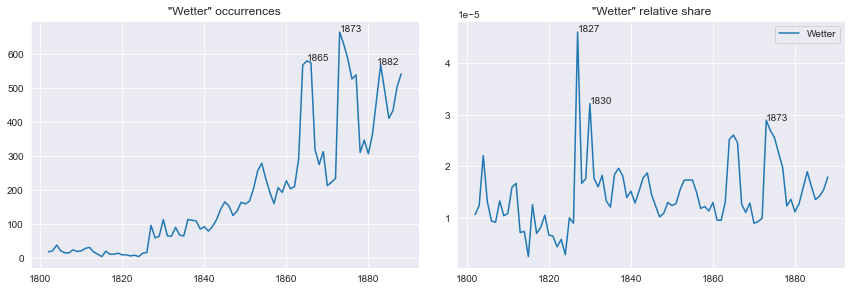

In [197]:
find_single_entity_freq(ents_ruled, wetter_witterung_list)

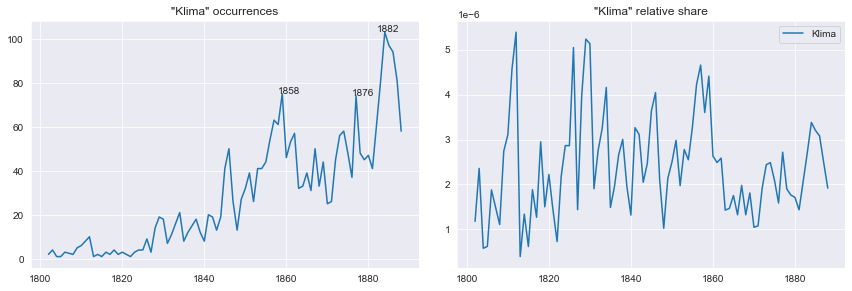

In [210]:
find_single_entity_freq(ents_ruled, klima_list)

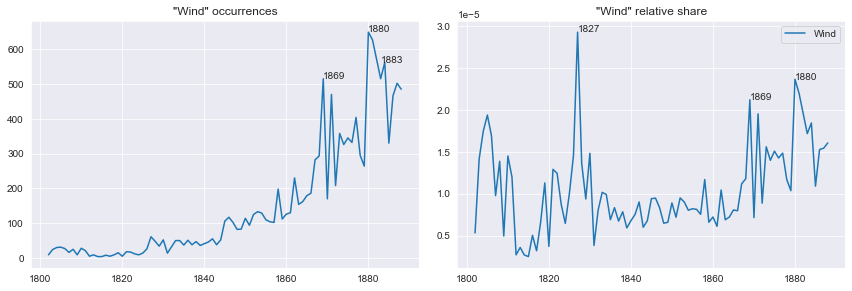

In [211]:
find_single_entity_freq(ents_ruled, ['Wind', 'Winde'])

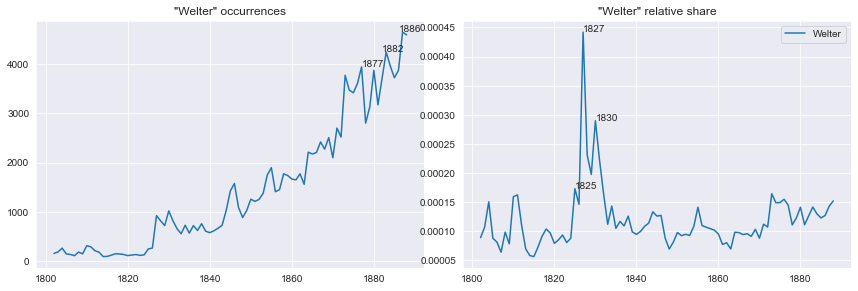

In [212]:
find_single_entity_freq(ents_ruled, wea_patterns)

In [221]:
ents_ruled[0]

{'id': 0, 'date': '1802-01-01', 'ents': {'WEA': []}}

In [229]:
def random_ents_from_year(year, df):
    ents_ruled_year = [ent for ent in ents_ruled if ent['date'][:4] == str(year)
                       and ent['ents']['WEA'] != []]
    
    year_df = df.loc[[ent['id'] for ent in ents_ruled_year]]
    
    print(f'{len(year_df)} texts with entities found from year {year}')
    
    while True:
        
        sample = year_df.sample()
        print('\n\n\n')
        print(sample.date.values[0], '\n')        
        print(sample.full_text.values[0])
        cont = input('continue? [Y]/n')
        if cont == 'n':
            break

In [230]:
random_ents_from_year(1827, df)

236 texts with entities found from year 1827




1827-01-25 

London, l?. Januar. Der gestrige Kvu» rier enthält Nachrichten aus Lissabon bis zum 2. d. Er bemerkt darüber: ~Aus den verschiedenen, im portug. Kriegs.Amt eingegan» penen Berichten scheint zu erhellen, daß di« Rebellen so thätig waren, daß die Truppen der Regierung genug zu thun hatten, auf olle ihre Bewegungen zu achten und ihren Spuren zu folgen, ohne fie zum Schlagen bringen zu können. Dieser ermüdende Krieg muß der

	England.

	Regierung sehr lästig fallen und gefahrbringend für die konstitutionelle Sache sey:,. Ein wich» tiger Umstand ist, dag die erste Nachricht von der Landung der engl. Truppen keinen Schreiten unter den Rebellen verbreitet hatte. Hierüber darf man sich jedoch nicht sehr «un, dem; die Rebellen führen eine verzweifelte Sache und wollen sie bis aufs Aeußerste tret, den; rechnen auch vielleicht auf das, was ste als eine zweideutige Beschaffenheit unserer Da» zwischenkunft ansehen. Sie folgern ohne Zweif

continue? [Y]/ny




1827-05-13 

Das niederländische Dampfschiff Willern de Eerste, geführt von Kapt. Jakob van den Oevcr, welches Sonnabend, den 5. Mai, Mor. GenS ~\ Uhr, von Hamburg abging, ist am 6. Mai, AbendS 9 Uhr, trotz der gehabten stür« mischen Witterung, in 37 Stunden in Amsterdam angekommen.
Dreöb en , iO. Mai. Vorgestern Vormkt. tagS wurde der hohe Leichnam Er. Maj. deS höchstseligen KönigS Friedrich August in dem Audienz. Zimmer auf das Paradebette gesetzt und zedermann von 10 biS 12 Uhr Mittags, so wie von 6 biS 7* Uhr AbendS, der Eingang in dieses Zimmer verstattet. Um 8 Uhr erfolgte mit den hergebrachten Eolennitäten die Bei-

	Deutschland.

	setzung in der k. Beg»uon&gt;pgruft unter der katholischen Hoftirche.
Berlin/ 12. Mai. Der Kaiser!, russ. wirkl. geh. Rath und Etaatsfekretair Graf Capodistrias ist von Paris hier angekommen.
(Börsen. Halle.)
AIS ein merkwürdiges Spiel des Zufalls hat man bemerkt, daß gerade vor 6 Jahren, fast um dieselbe Stunde, in welcher unser 

continue? [Y]/nj




1827-11-15 

Näheres über die Seeschlacht bei Navarin.

	Am 20. umMittag, wo der Wind günstig war, wurden die Zubereuungssignale gemacht; jeder nahm seinen Posten ein, das engl. Admiralschiff Afiaan berSpitze.gefolgtvom Albion u. Genoa, der Fregatte Sirene mlt der Flagge des Adm. Rigni, dem Scipion, Trident und Breslaw, dann dem russischen Admiralschiffe mit drei Linienschiffen und vier Fregatten.
Die Türken harten rundum in der Bai «ine Embossagelinie in Hufeifengestalt dreifach ge-, bildet, ein Ganzes von drei Linienschiffen, ei. nern rasirren Schiffe, ib Fregatten, 27 großen Korvetten und eben so vielen Briggs auS» wachend.
Die Hauptmacht war vom Einlaufe her rechtshin beisammen und bestand aus vier gro.

	Ben Fregatten, 2 Linienschiffen, einer großen Freyarte, einem Linienschiffe, dann aus Fregatten von verschiedenem Rang, die den Kon. Tour vollendeten und verstärkt in zweiter Linie durch die Korvetten und die Briggs.
Sechs Brander lagen an den äußersters Err* 

## Adjectives

In [1]:
import pandas as pd
from climdist.data import load as cd_load
import spacy
import json
from tqdm import tqdm

In [21]:
df = cd_load('main', readability=True, heading2=False)

In [19]:
nlp = spacy.load('de_core_news_md', disable=['ner'])

In [20]:
def find_adjectives(df, ents, nlp, label, ent_name, ent_strings):
    
    results = []
    
    for entry in tqdm(ents):
        if len(entry['ents'][label]) > 0:
            
            entry_ents = entry['ents'][label]
            entry_id = entry['id']
            #print(entry_id)
            
            # check if any of the ent labels are the ones we are looking for
            if set([ent[0] for ent in entry_ents]).intersection(ent_strings):
                    
                patterns = []
                                    
                for ent in entry_ents:
                    if ent[0] in ent_strings:
                        patterns.append({'label': 'WEA', 'pattern': ent[0]})
                                
                nlp.add_pipe('entity_ruler', last=True)
                ruler = nlp.get_pipe('entity_ruler')
                ruler.add_patterns(patterns)
                
                doc = nlp(df.full_text[entry_id])
                adjectives = []
                
                for token in doc:
                    if token.ent_type_ == label:
                        if token.pos_ in ['NOUN', 'PROPN']:
                            adjectives.extend([child.lemma_ for child in token.children if child.pos_ == 'ADJ'])
                            
                results.extend(adjectives)
                nlp.remove_pipe('entity_ruler')
                
                
            else:
                pass
             
        else:
            pass
        
        
    return {ent_name: results}            

In [22]:
regen_list = ['Regen', 'regen', 'Regenwetter', 'Negen', 'Regenschauer', 'Strichregen', 'Platzregen', 'Rege',
             'Regengüssen', 'Regens', 'RegenS', 'Regeu', 'Regenfall']

wetter_list = ['Welter', 'Witterung', 'Werter', 'Wetters', 'Witteruug', 'Witternng', 'WetterS']

In [129]:
if 'entity_ruler' in nlp.pipe_names:
    nlp.remove_pipe('entity_ruler')

regen_adjs = find_adjectives(df, ents, nlp, 'WEA', 'Regen', regen_list)
wetter_adjs = find_adjectives(df, ents, nlp, 'WEA', 'Wetter', wetter_list)

100%|█████████████████████████████████████████████████████████████████████████| 256996/256996 [24:35<00:00, 174.17it/s]


In [133]:
with open('../pipeline/ner/regen_adjectives.json', 'w', encoding='utf8') as f:
    json.dump(regen_adjs, f)
    
with open('../pipeline/ner/wetter_adjectives.json', 'w', encoding='utf8') as f:
    json.dump(wetter_adjs, f)

In [20]:
with open('../pipeline/ner/regen_adjectives.json', 'r', encoding='utf8') as f:
    regen_adjs = json.load(f)
    
with open('../pipeline/ner/wetter_adjectives.json', 'r', encoding='utf8') as f:
    wetter_adjs = json.load(f)

In [23]:
df_regen = pd.DataFrame(data=regen_adjs)
df_wetter = pd.DataFrame(data=wetter_adjs)

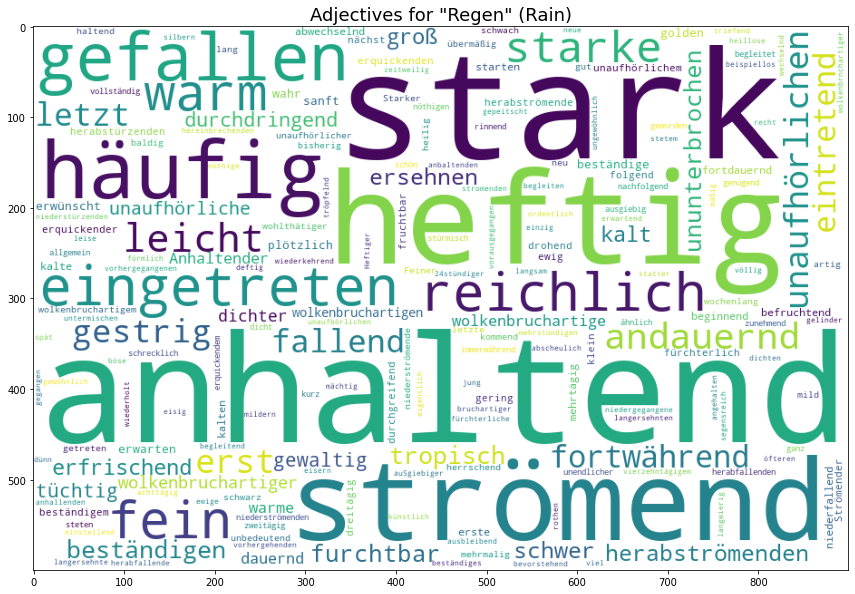

In [27]:
wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(df_regen['Regen'].value_counts().to_dict())
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.title('Adjectives for "Regen" (Rain)', size=18)
plt.savefig('../references/MM_workshop/regen_adjs.png', bbox_inches='tight')
plt.show()

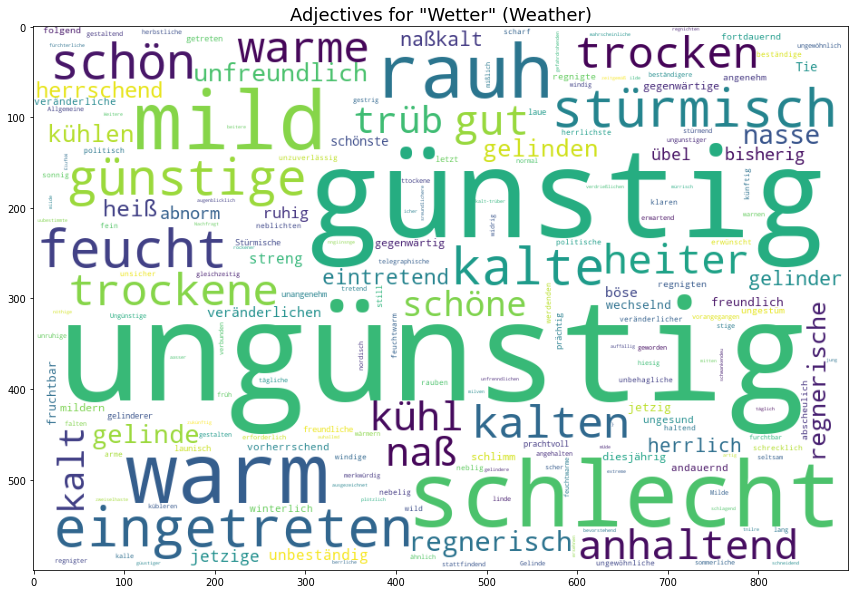

In [26]:
wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(df_wetter['Wetter'].value_counts().to_dict())
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.title('Adjectives for "Wetter" (Weather)', size=18)
plt.savefig('../references/MM_workshop/wetter_adjs.png', bbox_inches='tight')
plt.show()

### Try splitting the timerange for adjectives

In [16]:
def split_ents(ents, year):
    
    year = str(year)
    
    for ix, entry in enumerate(ents):
        if entry['date'][:4] == year:
            split_ix = ix
            break
            
    return ents[:split_ix], ents[split_ix:]

In [17]:
ents1, ents2 = split_ents(ents, 1850)

In [23]:
if 'entity_ruler' in nlp.pipe_names:
    nlp.remove_pipe('entity_ruler')

wetter_adjs_early = find_adjectives(df, ents1, nlp, 'WEA', 'Wetter', wetter_list)
wetter_adjs_late = find_adjectives(df, ents2, nlp, 'WEA', 'Wetter', wetter_list)

100%|█████████████████████████████████████████████████████████████████████████| 159941/159941 [22:07<00:00, 120.52it/s]


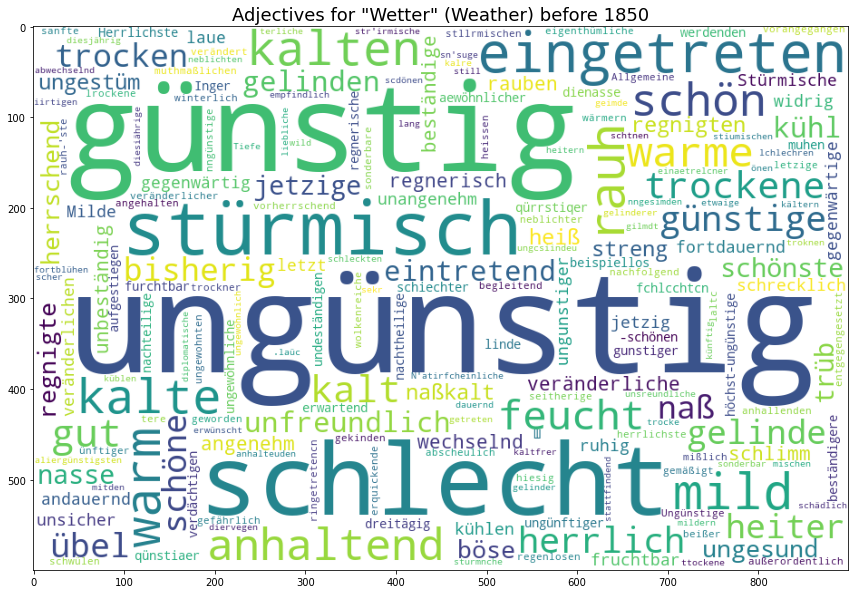

In [26]:
df_wetter_early = pd.DataFrame(data=wetter_adjs_early)

wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(df_wetter_early['Wetter'].value_counts().to_dict())
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.title('Adjectives for "Wetter" (Weather) before 1850', size=18)
plt.savefig('../references/inalco/wetter_adjs_early.png', bbox_inches='tight')
plt.show()

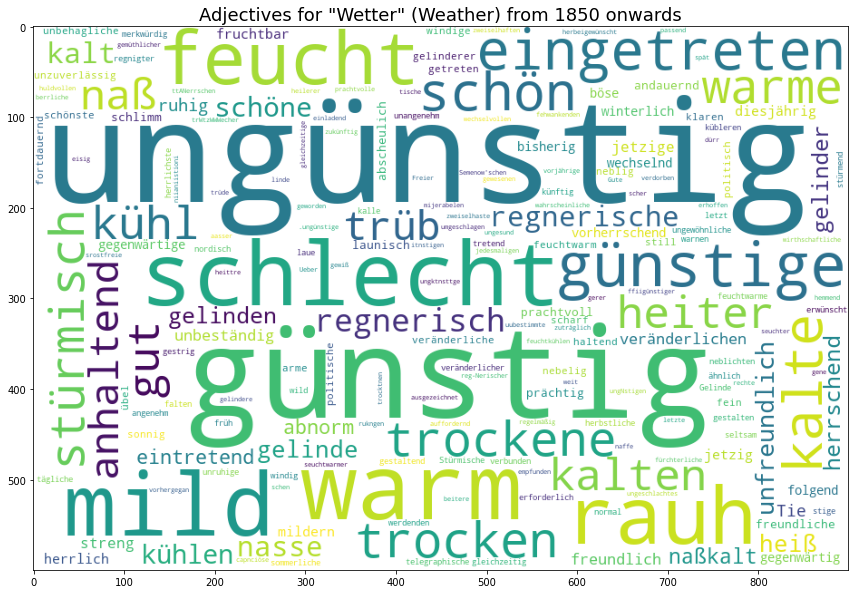

In [27]:
df_wetter_late = pd.DataFrame(data=wetter_adjs_late)

wc = WordCloud(background_color='white', width=900, height=600)
wc.generate_from_frequencies(df_wetter_late['Wetter'].value_counts().to_dict())
plt.figure(figsize=(15,10))
plt.imshow(wc)
plt.title('Adjectives for "Wetter" (Weather) from 1850 onwards', size=18)
plt.savefig('../references/inalco/wetter_adjs_late.png', bbox_inches='tight')
plt.show()

In [105]:
df_wetter_early['Wetter'].value_counts()[:10]

ungünstig      106
günstig         80
schlecht        49
stürmisch       35
eingetreten     27
warm            21
mild            21
rauh            20
kalten          19
kalte           19
Name: Wetter, dtype: int64

In [106]:
df_wetter_late['Wetter'].value_counts()[:10]

ungünstig      299
günstig        236
warm           108
schlecht       100
mild            97
rauh            79
feucht          66
günstige        60
eingetreten     60
kalte           55
Name: Wetter, dtype: int64

## PCA

Continue with ruled entities (less false positives)

In [61]:
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [35]:
model = gensim.models.keyedvectors.KeyedVectors.load_word2vec_format('../data/models/word2vec_251021/w2v_model.txt')

In [137]:
df_data = {word: list(model[word]) for (word, freq) in
           list(wea_freqs_ruled.items())[:100]
           if model.has_index_for(word)}
df = pd.DataFrame(df_data).transpose()
df.head()

0         1         2         3         4         5   \
Wind       3.997121 -1.997144 -0.896162 -1.015114 -0.644477  5.687706   
Regen      4.597841 -1.278705 -0.924405 -0.310730  4.019860  6.215589   
Wetter     1.378204 -2.707503 -2.039176  1.217988  2.243737  7.249822   
Sturm      1.347576 -2.298337 -2.150306  2.419630 -0.502169  2.543556   
Witterung -0.005538 -7.517947 -0.256603 -0.812336  3.149959  6.066840   

                 6         7         8         9   ...        90        91  \
Wind      -0.398044 -4.558488 -2.631009  0.409658  ... -2.136814  0.583438   
Regen      0.146798 -1.136845  1.547163 -0.099335  ... -1.369600 -0.462511   
Wetter     0.605895 -0.760818  1.997465  1.639767  ... -1.648705  0.733798   
Sturm     -1.054247 -1.456778 -0.222191  1.185702  ... -0.365058  1.056712   
Witterung -0.382613 -0.186831  2.737664  0.334570  ... -2.412435 -0.453090   

                 92        93        94        95        96        97  \
Wind       3.231198  1.095965 -1.395962  1.187891  0.579628  2.233373   
Regen      1.295471 -0.558615 -2.030243  1.398353 -1.667691 -1.582838   
Wetter     1.211946  4.739862 -3.160194  3.041113 -2.772848 -0.826249   
Sturm      2.059589 -1.064057 -0.979120  0.971783 -1.894031 -1.059706   
Witterung  0.055757  1.896720 -4.634286  2.564435 -0.422497  1.706759   

                 98        99  
Wind       0.842518  1.585546  
Regen     -2.764452 -0.416062  
Wetter     0.374688 -1.111655  
Sturm     -0.686569 -0.804395  
Witterung -0.234471  0.613567  

[5 rows x 100 columns]

In [139]:
# from: https://www.youtube.com/watch?v=Lsue2gEM9D0

pca = PCA()
pca.fit(df[:50])
pca_data = pca.transform(df[:50])

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

In [135]:
# plt.figure(figsize=(18,6))
# plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
# plt.ylabel('Percentage of Explained Variance')
# plt.xlabel('Principal Component')
# plt.title('Scree Plot')
# plt.show()

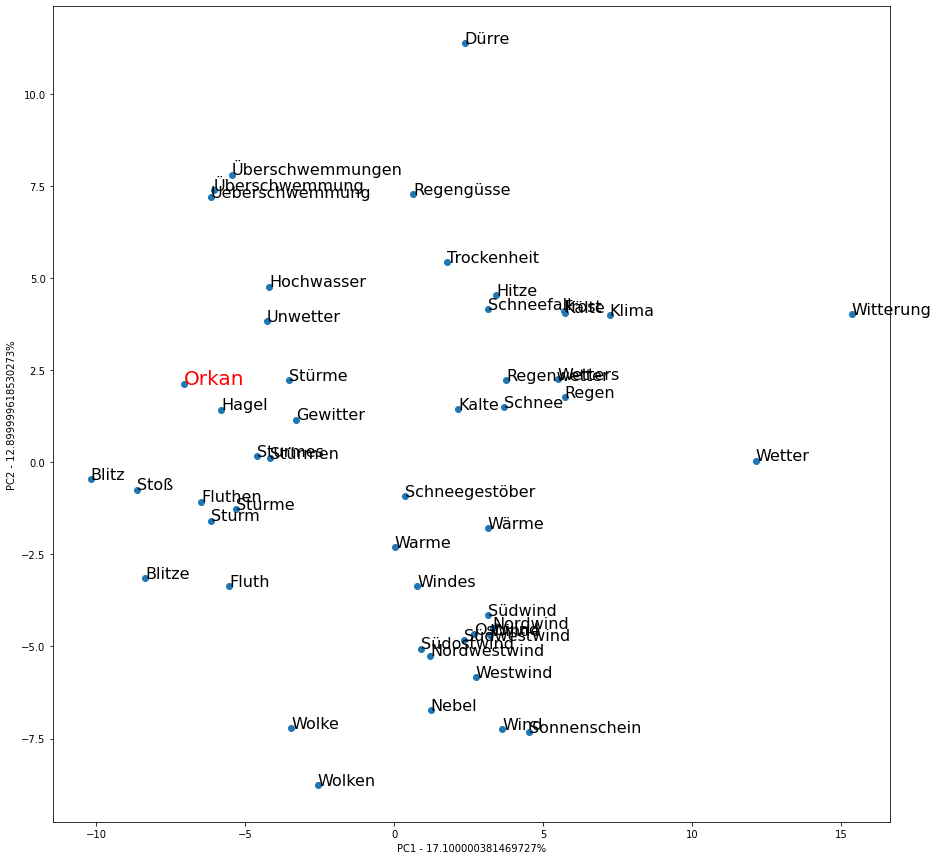

In [142]:
pca_df = pd.DataFrame(data=pca_data, index=df[:50].index, columns=labels)

plt.figure(figsize=(15,15))

plt.scatter(pca_df.PC1, pca_df.PC2)
plt.xlabel('PC1 - {0}%'.format(round(per_var[0], 2)))
plt.ylabel('PC2 - {0}%'.format(round(per_var[1], 2)))
 
for sample in pca_df.index:
    if sample == 'Orkan':
        plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]), size=20, color='red')
    else:
        plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]), size=16)
        
plt.savefig('../references/inalco/orkan_pca.png', bbox_inches='tight')
plt.show()

## Geographical representation

In [130]:
def load_places(cities_minpop):
                   
    countries = pd.read_csv('../data/external/geonames/countries150721.tsv', sep='\t', encoding='utf8').convert_dtypes()
    cities = pd.read_csv('../data/external/geonames/cities150721.tsv', sep='\t', encoding='utf8').convert_dtypes()
    cities = cities[(cities.feature_code == 'PPLC')|(cities.population >= cities_minpop)]
    regions = pd.read_csv('../data/external/geonames/regions280721.tsv', sep='\t', encoding='utf8').convert_dtypes()
                   
    places = pd.concat([countries, cities, regions])
    places.name = ',' + places.name + ',' + places.alternatenames + ','
    places = places[['geonameid', 'name', 'y', 'x', 'population']]
    places = places.rename(columns={'name': 'names'})
                   
    return places

In [133]:
load_places(10000)

geonameid                                              names         y  \
0      3041565  ,Principality of Andorra,'Enitola,Andora,Andor...     42.55   
1       290557  ,United Arab Emirates,'Alepea Fakatahataha,A-l...     23.75   
2      1149361  ,Islamic Republic of Afghanistan,'Afikanisitan...      33.0   
3      3576396  ,Antigua and Barbuda,Aintige agus Barbuda,Aint...     17.05   
4       783754  ,Republic of Albania,'Alipania,Al'banija,Albaa...      41.0   
..         ...                                                ...       ...   
527   12216908                                               <NA>  43.97233   
528   12217848                                               <NA>  50.28762   
529   12217933                                               <NA>  57.29568   
530   12217934  ,Baltic States,https://en.wikipedia.org/wiki/B...  56.85514   
531   12218088  ,Arab Gulf Countries,Arab states of the Persia...  26.35058   

            x  population  
0     1.58333       77006  
1        54.5     9630959  
2        66.0    37172386  
3       -61.8       96286  
4        20.0     2866376  
..        ...         ...  
527  22.11567    64630000  
528   15.1903   166180000  
529  19.48591    73370000  
530  25.32515     6040000  
531  50.16805    95080000  

[25280 rows x 5 columns]

In [ ]:
def get_geodata(df, ents, year):
    
    df = pd.DataFrame(columns=)
    
    headings = df.heading2[(df.year == year) & (df.heading_loc == True)]
    headings = headings.value_counts().reset_index(name='count')
    headings = headings[headings['count'] > 1]
    headings = headings.rename(columns={'index': 'name'})
    
    headings['x'] = np.nan
    headings['y'] = np.nan
    
    notfound = []
    
    for name in headings.name:
        match = places[places.names.str.contains(','+name+',')]
        if len(match) == 1:
            headings.loc[headings.name == name, 'x'] = match.x.values
            headings.loc[headings.name == name, 'y'] = match.y.values
        elif len(match) > 1:
            match = match[match.population == max(match.population)]
            if len(match) == 1:
                headings.loc[headings.name == name, 'x'] = match.x.values
                headings.loc[headings.name == name, 'y'] = match.y.values
            else:
                match = match.sample(1)
                headings.loc[headings.name == name, 'x'] = match.x.values
                headings.loc[headings.name == name, 'y'] = match.y.values
        elif len(match) == 0:
            notfound.append(name)
            
    headings.dropna(0, 'any', inplace=True)
                        
    return headings.to_dict()

## Stuff for seminar presentation

In [120]:
model.most_similar('Wind')

[('Winde', 0.8186328411102295),
 ('Windes', 0.7385551333427429),
 ('Wmd', 0.7353512644767761),
 ('Wiud', 0.7123661637306213),
 ('wind', 0.6971095204353333),
 ('Nordost', 0.6854856014251709),
 ('Südwestwinde', 0.6780210137367249),
 ('Regen', 0.6760525703430176),
 ('Südost', 0.670193612575531),
 ('Brise', 0.6647733449935913)]

In [144]:
model.most_similar('Wetter')

[('Welter', 0.8512787818908691),
 ('Witterung', 0.816821277141571),
 ('Herbstwetter', 0.7820582389831543),
 ('Frühlingswetter', 0.775166928768158),
 ('Werter', 0.7462899684906006),
 ('Regenwetter', 0.744738757610321),
 ('Wetters', 0.7302265167236328),
 ('Sommerwetter', 0.7302024364471436),
 ('FrühlingSwetter', 0.719641387462616),
 ('anhaltend', 0.712823748588562)]

In [155]:
wea_freqs_early

{'Sturm': 3193,
 'Regen': 2533,
 'Wetter': 2433,
 'Schnee': 2431,
 'Witterung': 1924,
 'Wind': 1866,
 'Kälte': 1603,
 'Hitze': 1509,
 'Winde': 1007,
 'Sonnenschein': 922,
 'Wärme': 864,
 'Klima': 805,
 'Gewitter': 694,
 'Nebel': 678,
 'Blitz': 662,
 'Wolken': 648,
 'Frost': 634,
 'Stoß': 604,
 'Stürme': 552,
 'Hagel': 518,
 'Sturme': 496,
 'Fluth': 441,
 'Orkan': 359,
 'Dürre': 324,
 'Sturmes': 307,
 'Wetters': 269,
 'Stürmen': 264,
 'Kalte': 263,
 'Überschwemmung': 256,
 'Wolke': 249,
 'Regengüsse': 248,
 'Windes': 220,
 'Schneegestöber': 207,
 'Blitze': 197,
 'Überschwemmungen': 195,
 'Thau': 188,
 'Fluthen': 188,
 'Windstille': 186,
 'Ueberschwemmung': 177,
 'Unwetter': 176,
 'Regenwetter': 168,
 'Regens': 165,
 'Winden': 147,
 'Warme': 136,
 'Ueberschwemmungen': 135,
 'Schnees': 132,
 'Regenzeit': 130,
 'Thauwetter': 129,
 'Trockenheit': 124,
 'Schneefall': 123,
 'Nordwest': 116,
 'Nordwind': 114,
 'Klimas': 105,
 'Windstoß': 93,
 'Platzregen': 92,
 'Blitzstrahl': 90,
 'Ungewitter'

In [156]:
wea_freqs_late

{'Wind': 7670,
 'Regen': 6237,
 'Wetter': 5602,
 'Witterung': 5166,
 'Wärme': 4860,
 'Schnee': 4528,
 'Sturm': 4191,
 'Kälte': 3088,
 'Nebel': 2052,
 'Winde': 1895,
 'Hitze': 1821,
 'Frost': 1765,
 'Klima': 1305,
 'Gewitter': 1272,
 'Wolken': 1077,
 'Blitz': 974,
 'Stoß': 970,
 'Fluth': 900,
 'Westwind': 768,
 'Nordwind': 751,
 'Hagel': 727,
 'Sturme': 716,
 'Dürre': 663,
 'Sonnenschein': 650,
 'Stürme': 632,
 'Südwind': 621,
 'Ostwind': 580,
 'Unwetter': 579,
 'Schneefall': 538,
 'Südwestwind': 532,
 'Wolke': 461,
 'Südostwind': 412,
 'Orkan': 411,
 'Nordwestwind': 401,
 'Trockenheit': 383,
 'Hochwasser': 382,
 'Regengüsse': 378,
 'Stürmen': 352,
 'Nordostwind': 348,
 'Windrichtung': 344,
 'Regenwetter': 341,
 'Überschwemmung': 328,
 'Fluthen': 326,
 'Schneegestöber': 315,
 'Ueberschwemmung': 312,
 'Warme': 308,
 'Wetters': 305,
 'Sturmes': 300,
 'Thauwetter': 285,
 'Windes': 277,
 'Stegen': 271,
 'Rege': 266,
 'Blitze': 258,
 'Niederschlag': 252,
 'Nordwest': 247,
 'Taikun': 241,
 'Ü